# Graph Theoretical Analysis

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import SigProc 
from analysis.graph_analysis_utils import NeuronNetwork
import analysis.analysis_utils as au
import analysis.resampling as rs
from scipy import stats
from IPython.core.interactiveshell import InteractiveShell

In [2]:
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/EPM")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

animal_data_files = dict()

for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    if subdir_list:
        mice_directories = subdir_list

    for file_name in file_list:
        for mouse_name in mice_directories:
            if file_name.endswith(".csv") and (mouse_name in file_name and "behavior" in file_name):
                if mouse_name in animal_data_files:
                    animal_data_files[mouse_name].update({"behavior": os.path.join(dir_name, file_name)})
                else:
                    animal_data_files[mouse_name] = {"behavior": os.path.join(dir_name, file_name)}
            elif file_name.endswith(".csv") and (mouse_name in file_name and "Raw" in file_name):
                if mouse_name in animal_data_files:
                    animal_data_files[mouse_name].update({"Raw": os.path.join(dir_name, file_name)})
                else:
                    animal_data_files[mouse_name] = {"Raw": os.path.join(dir_name, file_name)}

## Store all neuron activity and corresponding behavior dataframes, for each animal, in a dictionary

In [4]:
animal_dataframes = dict()

for animal_name in animal_data_files:
    print(animal_name)
    
    data = pd.read_csv(animal_data_files[animal_name]["Raw"], header=None)
    
    if animal_name == "drd73" or animal_name == "drd77":
        data = au.downsample_dataframe(data,2)
    _, _, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)
    
    # Rename all the columns from "neuron_x" --> "x". This makes the graphs neater by making sure the neuron names fit into the nodes
    cell_transients_dataframe.columns = [i for i in range(1, len(cell_transients_dataframe.columns)+1)]
    
    behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

    behavior_df = pd.read_csv(animal_data_files[animal_name]["behavior"], header=None)
    behavior_df.columns = behavior_column_names
    
    # Only keep every 3rd row of the original behavior dataframe in order to downsample 30 fps --> 10 fps
    behavior_df = au.downsample_dataframe(behavior_df, 3)

    # Define cutoff for what constitutes as a running frame
    VELOCITY_CUTOFF = 4;

    # Adds "Running_frames" column to the end of the behavior dataframe 
    behavior_df["Running_frames"] = np.where(behavior_df["Velocity"] > VELOCITY_CUTOFF, 1, 0)
    
    neuron_concated_behavior = cell_transients_dataframe.join(behavior_df, how="left")
    
    if not animal_name in animal_dataframes:
        animal_dataframes[animal_name] = {"cell transients": cell_transients_dataframe, "behavior": behavior_df, "neuron and beh": neuron_concated_behavior}

drd87
drd73
drd77
drd46


## Now, we plot an undirected graph of the network of cells that were imaged for a given mouse
- Edges are added between pairs of neurons that had a correlation coefficient $\ge 3.0$
    - Each edge is weighted by the correlation coefficient corresponding to the two neurons it connects
    - The correlation coefficient between each corresponding pair of neurons is drawn on the edge between them
    - The color of each edge is determined by the correlation between the pair of neurons: 
        - yellow - correlated
        - green - strongly correlated 
        - blue - very strongly correlated
- Isolate nodes are also plotted
- No clustering algorithm was applied to this network of nodes... the graph drawing algorithm that was utilized keeps corresponding nodes clustered together by accounting for the weights of the edges
- Note that the clusters of nodes strongly correspond to the clusters created by the Seaborn library's cluster map data visualization

## In complex networks, the degree distributions are non-Gaussian, and often have a long tail towards high degrees (Bullmore et al. 2009)
## So, we plot the network of neurons for `drd87` when it was in the open arms, and we follow it up with the degree distribution of the neuronal network in the open arms. We do the same for `drd87` in the closed arms.

#### **Note**: "Some networks (including the Internet and the World Wide Web) have degree distributions in the form of a power law: that is, the probability that a node has degree $k$ is given as $Prob(k)$ ~ $k – \lambda$. In biological systems, the degree exponent $\lambda$ often ranges between $2$ and $3$, and the very gradual (‘heavy-tail’) power law decay of the degree distribution implies that the network lacks a characteristic scale — hence such networks are called ‘scale-free’ networks. Barabási and Albert demonstrated that scale-free networks can originate from a process by which each node that is added to the network as it grows connects preferentially to other nodes that already have high degree. Scale-free networks are unlikely if the attachment of connections is subject to physical constraints or associated with a cost. Therefore, physically embedded networks, in which nodes have limited capacity for making connections, often do not have pure power law degree distributions but may instead demonstrate exponentially truncated power law degree distributions, which are associated with a lower probability of very high degree nodes." (Bullmore et. al 2009)



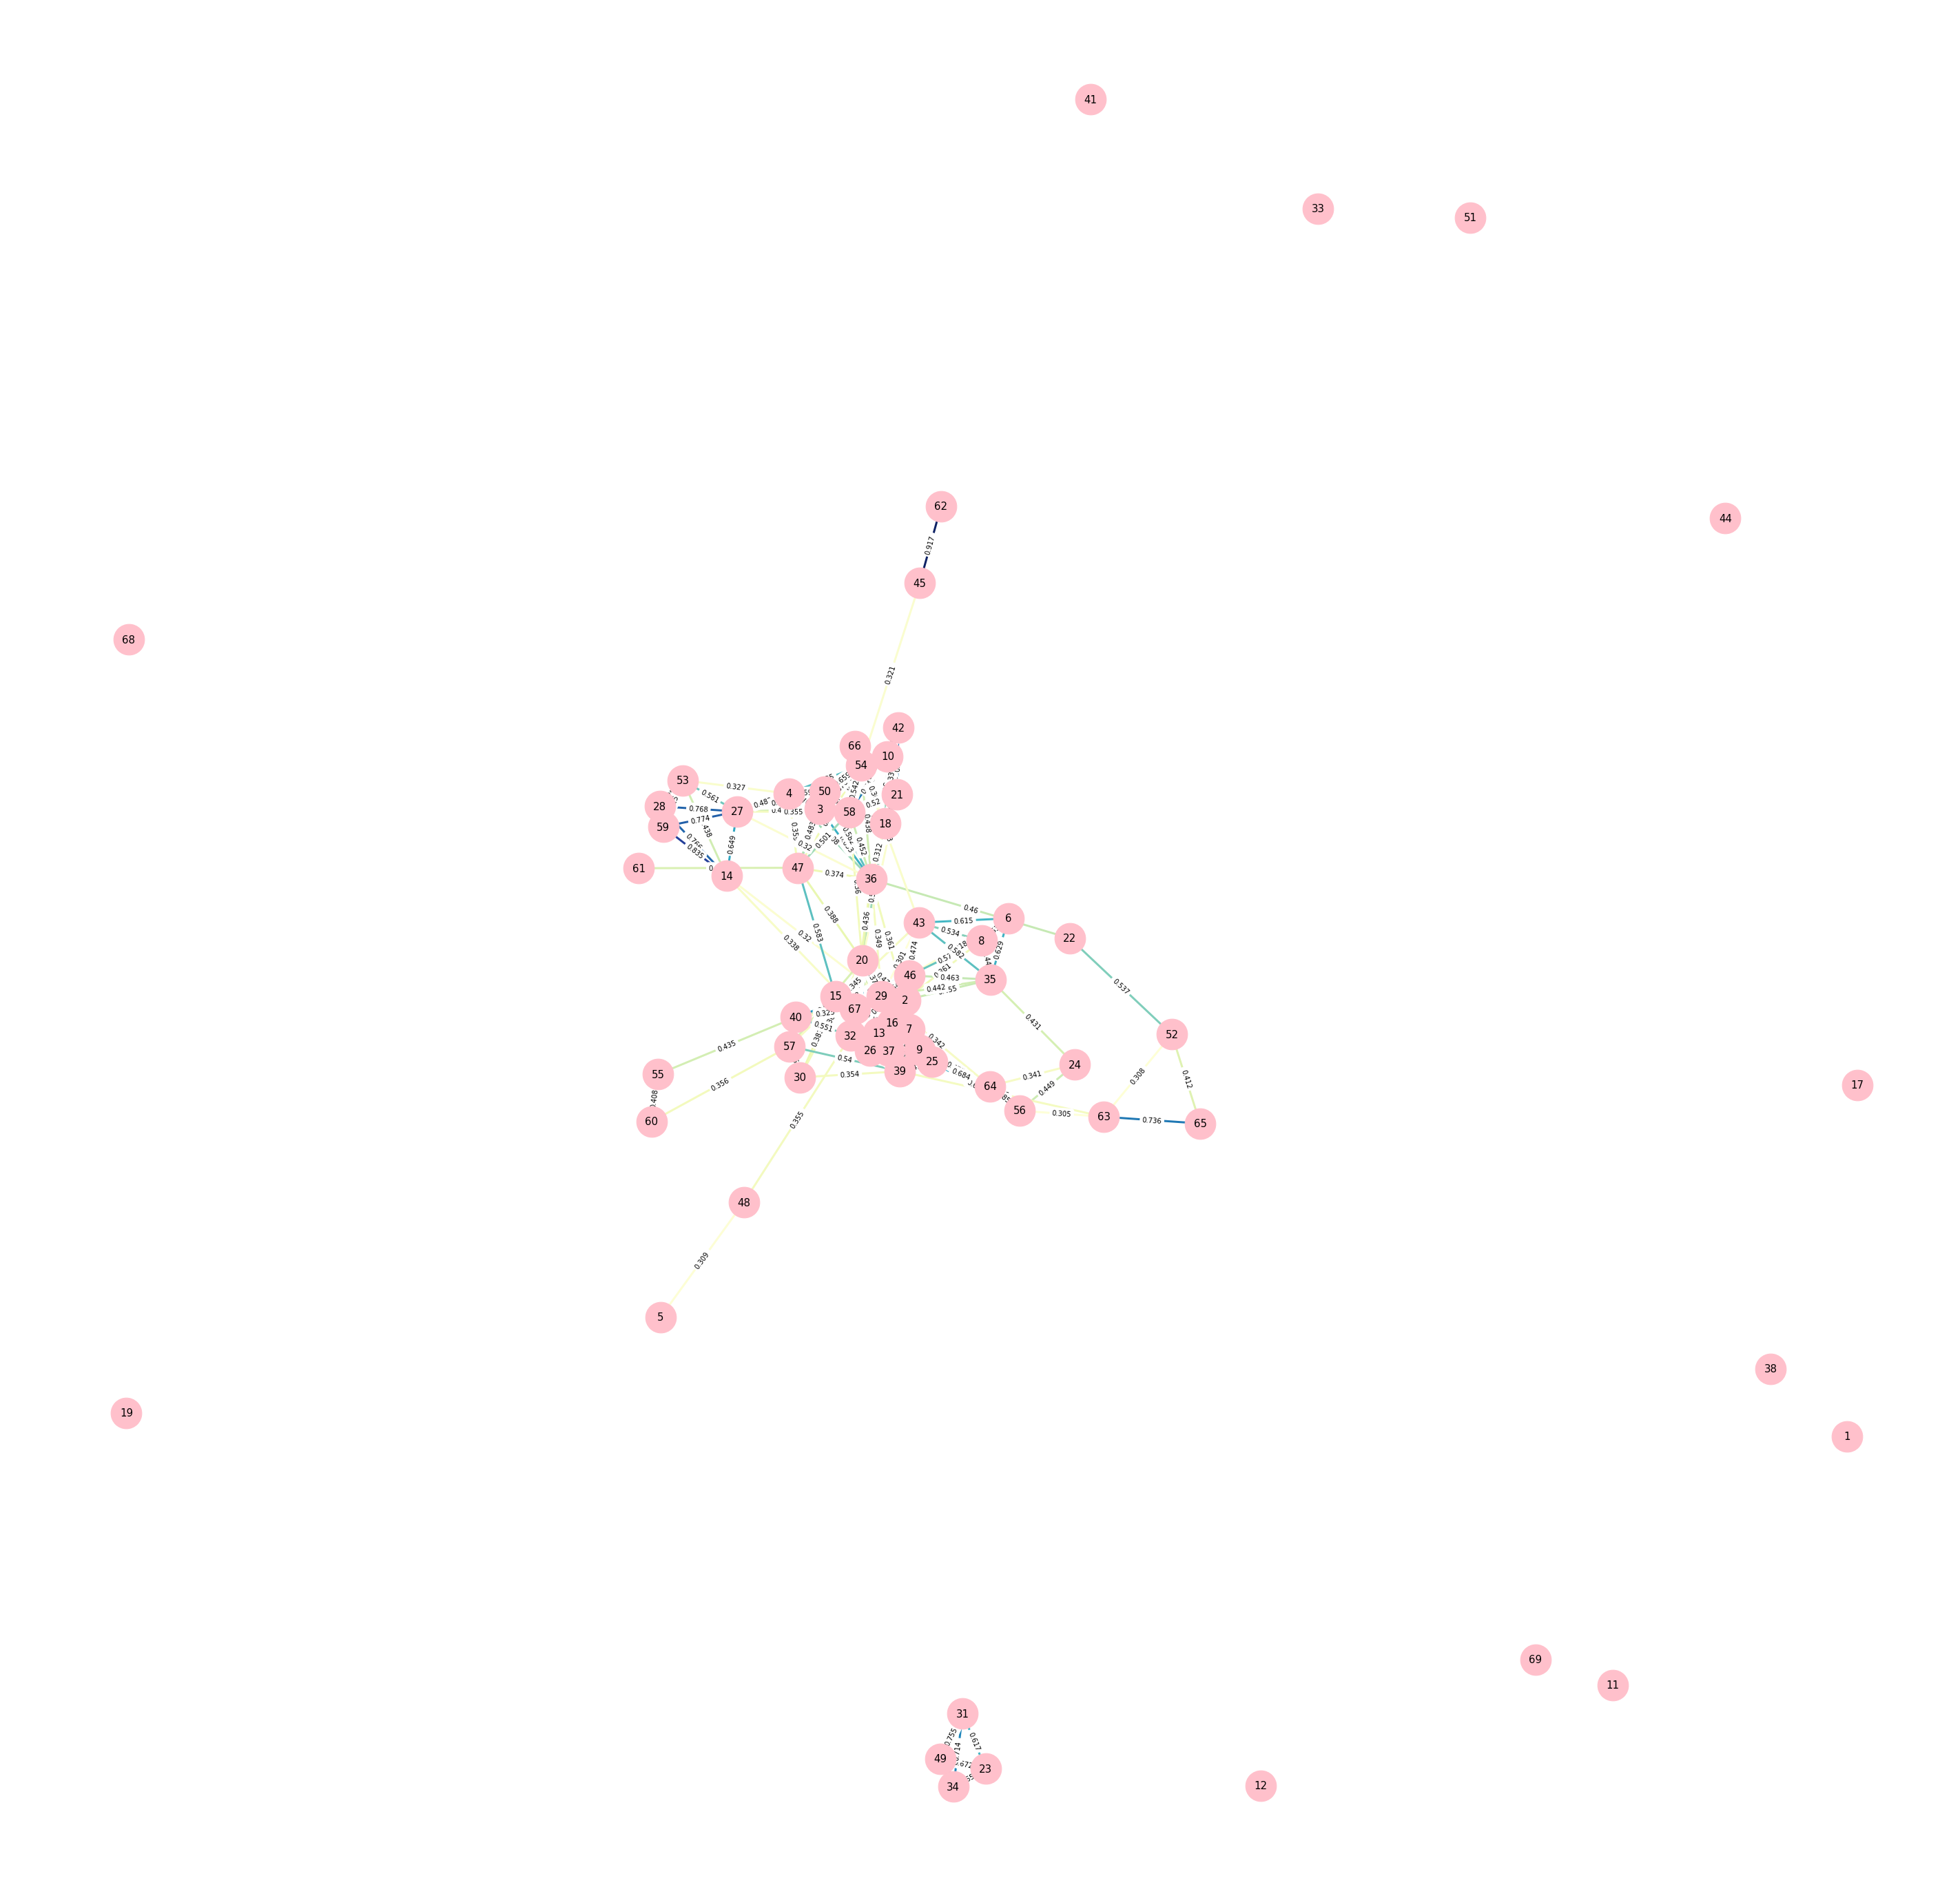

/anaconda3/envs/henlabenv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



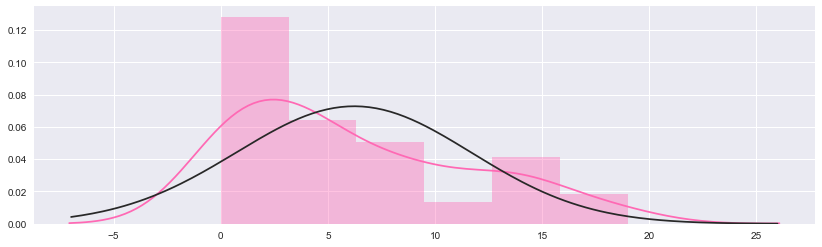

In [5]:
animal = "drd87"

indices = animal_dataframes[animal]["neuron and beh"].loc[animal_dataframes[animal]["neuron and beh"]["OpenArms_centerpoint"] != 0].index
drd87_open_arms = NeuronNetwork(animal_dataframes[animal]["cell transients"].iloc[indices])

drd87_open_arms.plot_with_spring_layout(figsize=(50,50), node_color="pink", node_size=2000, save=False, file_name="drd87_open_arms_graph.png")
sns.set(rc={"figure.figsize": (14, 4)})
sns.distplot(list(dict(drd87_open_arms.network.degree()).values()), color='hotpink', fit=stats.loggamma);

## Bar plot of node degree in the **Open Arms**

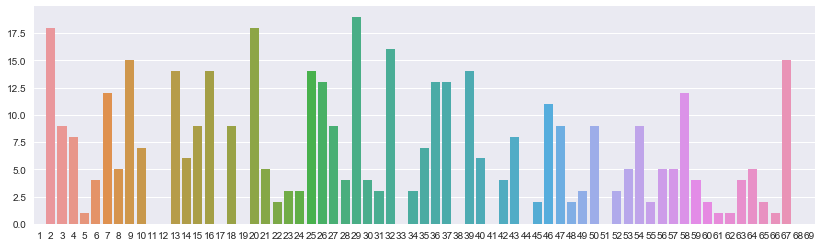

In [6]:
sns.barplot(x=list(dict(drd87_open_arms.network.degree()).keys()), y=list(dict(drd87_open_arms.network.degree()).values()));

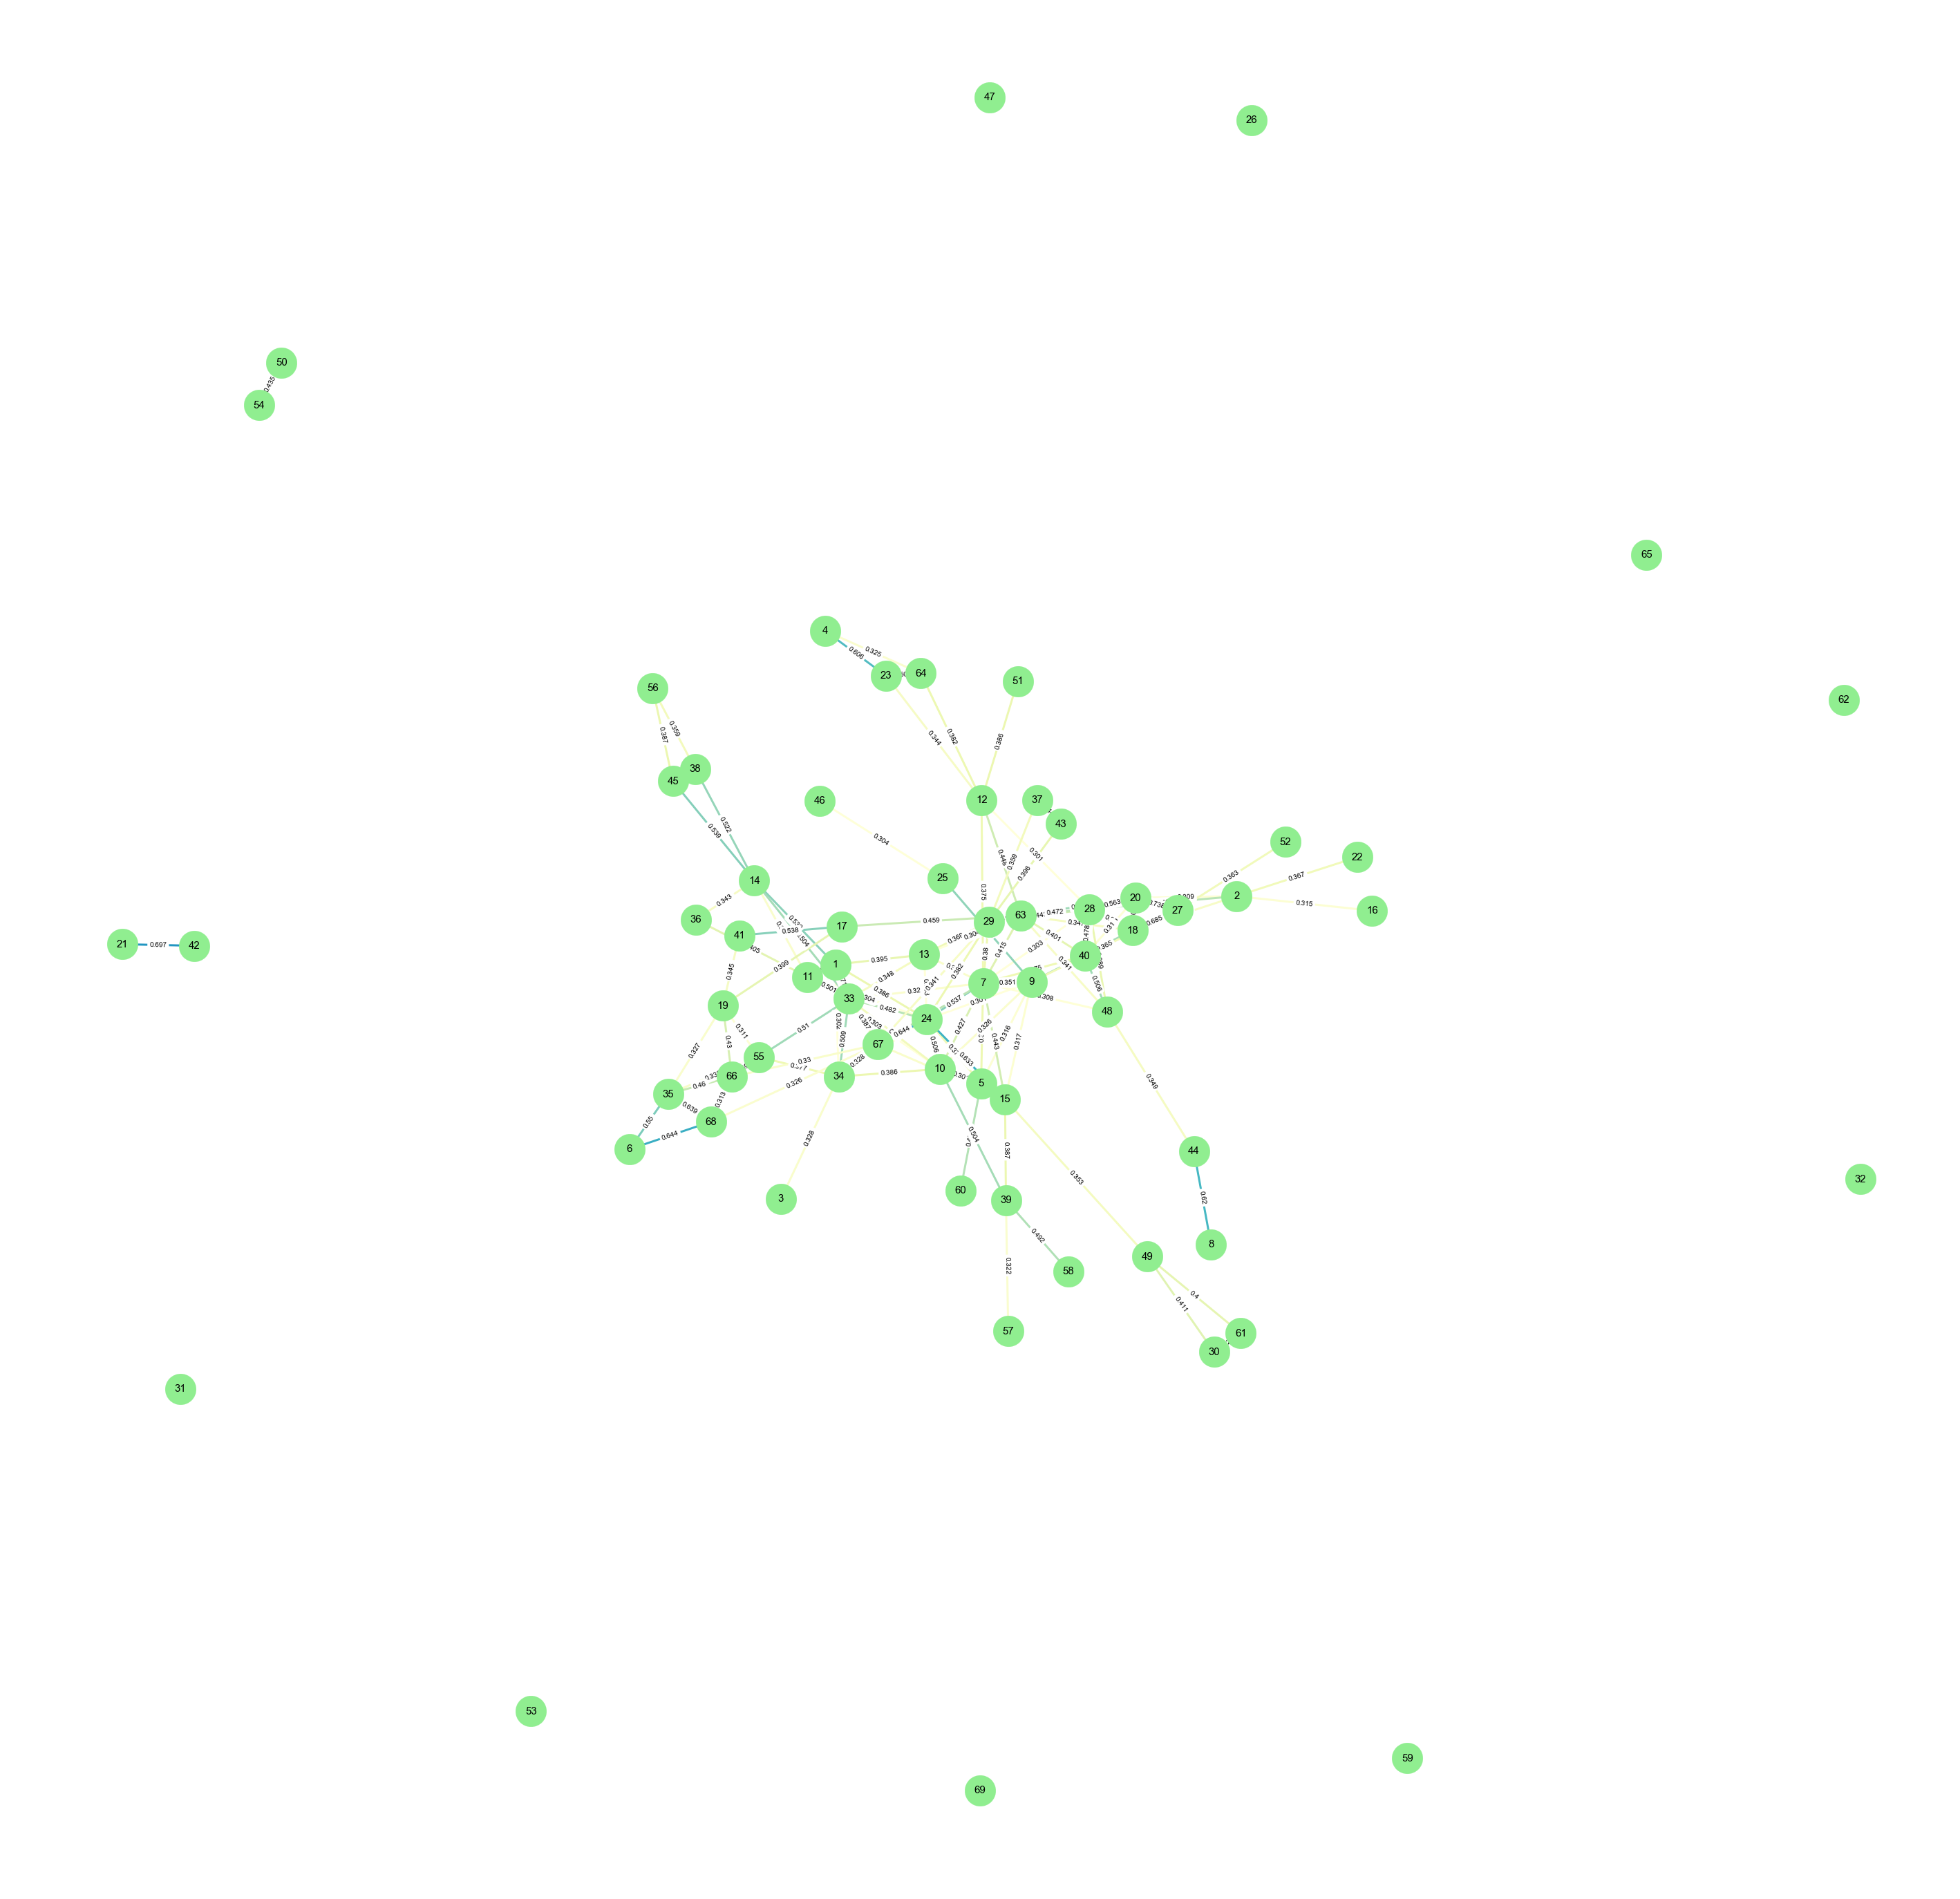

/anaconda3/envs/henlabenv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



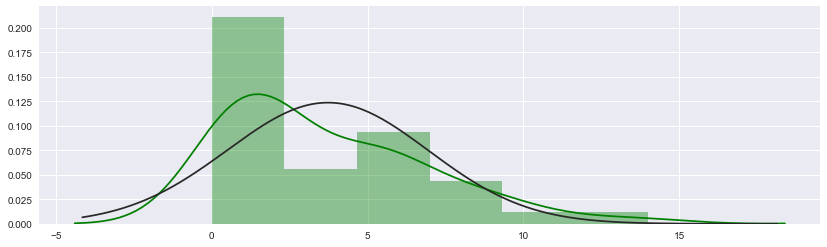

In [7]:
indices = animal_dataframes[animal]["neuron and beh"].loc[animal_dataframes[animal]["neuron and beh"]["ClosedArms_centerpoint"] != 0].index
drd87_closed_arms = NeuronNetwork(animal_dataframes[animal]["cell transients"].iloc[indices])

drd87_closed_arms.plot_with_spring_layout(figsize=(50,50), node_color="lightgreen", node_size=2000, save=False, file_name="drd87_closed_arms_graph.png")
sns.set(rc={"figure.figsize": (14, 4)})
sns.distplot(list(dict(drd87_closed_arms.network.degree()).values()), color='green', fit=stats.loggamma);

## Bar plot of node degree in the **Closed Arms**

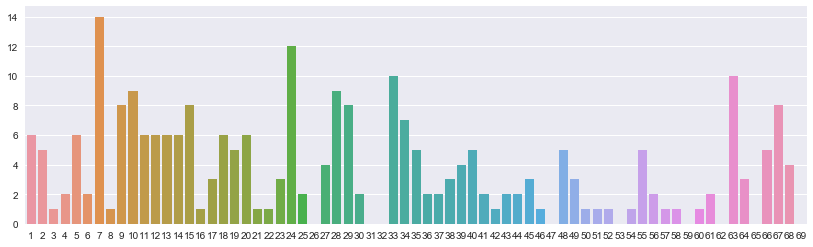

In [8]:
sns.barplot(x=list(dict(drd87_closed_arms.network.degree()).keys()), y=list(dict(drd87_closed_arms.network.degree()).values()));

## Plot the graph of the network while the mouse was in the closed arms. Nodes are colored is based on their betweenness centrality, from least (light-blue) to greatest (neon-purple).

In [9]:
indices = neuron_concated_behavior.loc[neuron_concated_behavior["ClosedArms_centerpoint"] != 0].index
closed_arms_graph = NeuronNetwork(cell_transients_dataframe.iloc[indices])

def plot_by_color(graph, feature_func, **kwargs):
    feature_dict = feature_func(graph)

    plt.figure(figsize=kwargs.get("figsize", (35, 35)))

    pos = nx.spring_layout(graph, weight="weight") 

    vmax = max(list(feature_dict.values()))
    vmin = min(list(feature_dict.values()))

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color=list(feature_dict.values()), cmap=plt.cm.cool, vmax=vmax, vmin=vmin);

    edges, weights = zip(*nx.get_edge_attributes(graph, "weight").items())

    # edges
    nx.draw_networkx_edges(graph, pos, width=3.0, edge_color=weights, edge_cmap=plt.cm.YlGnBu);

    labels = nx.get_edge_attributes(graph, "weight")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=15, edge_labels=labels)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm)

    plt.axis('off');
    plt.show();

# We plot the network of drd87's neurons in the open arms. Note: nodes are colored by their corresponding degree centrality.

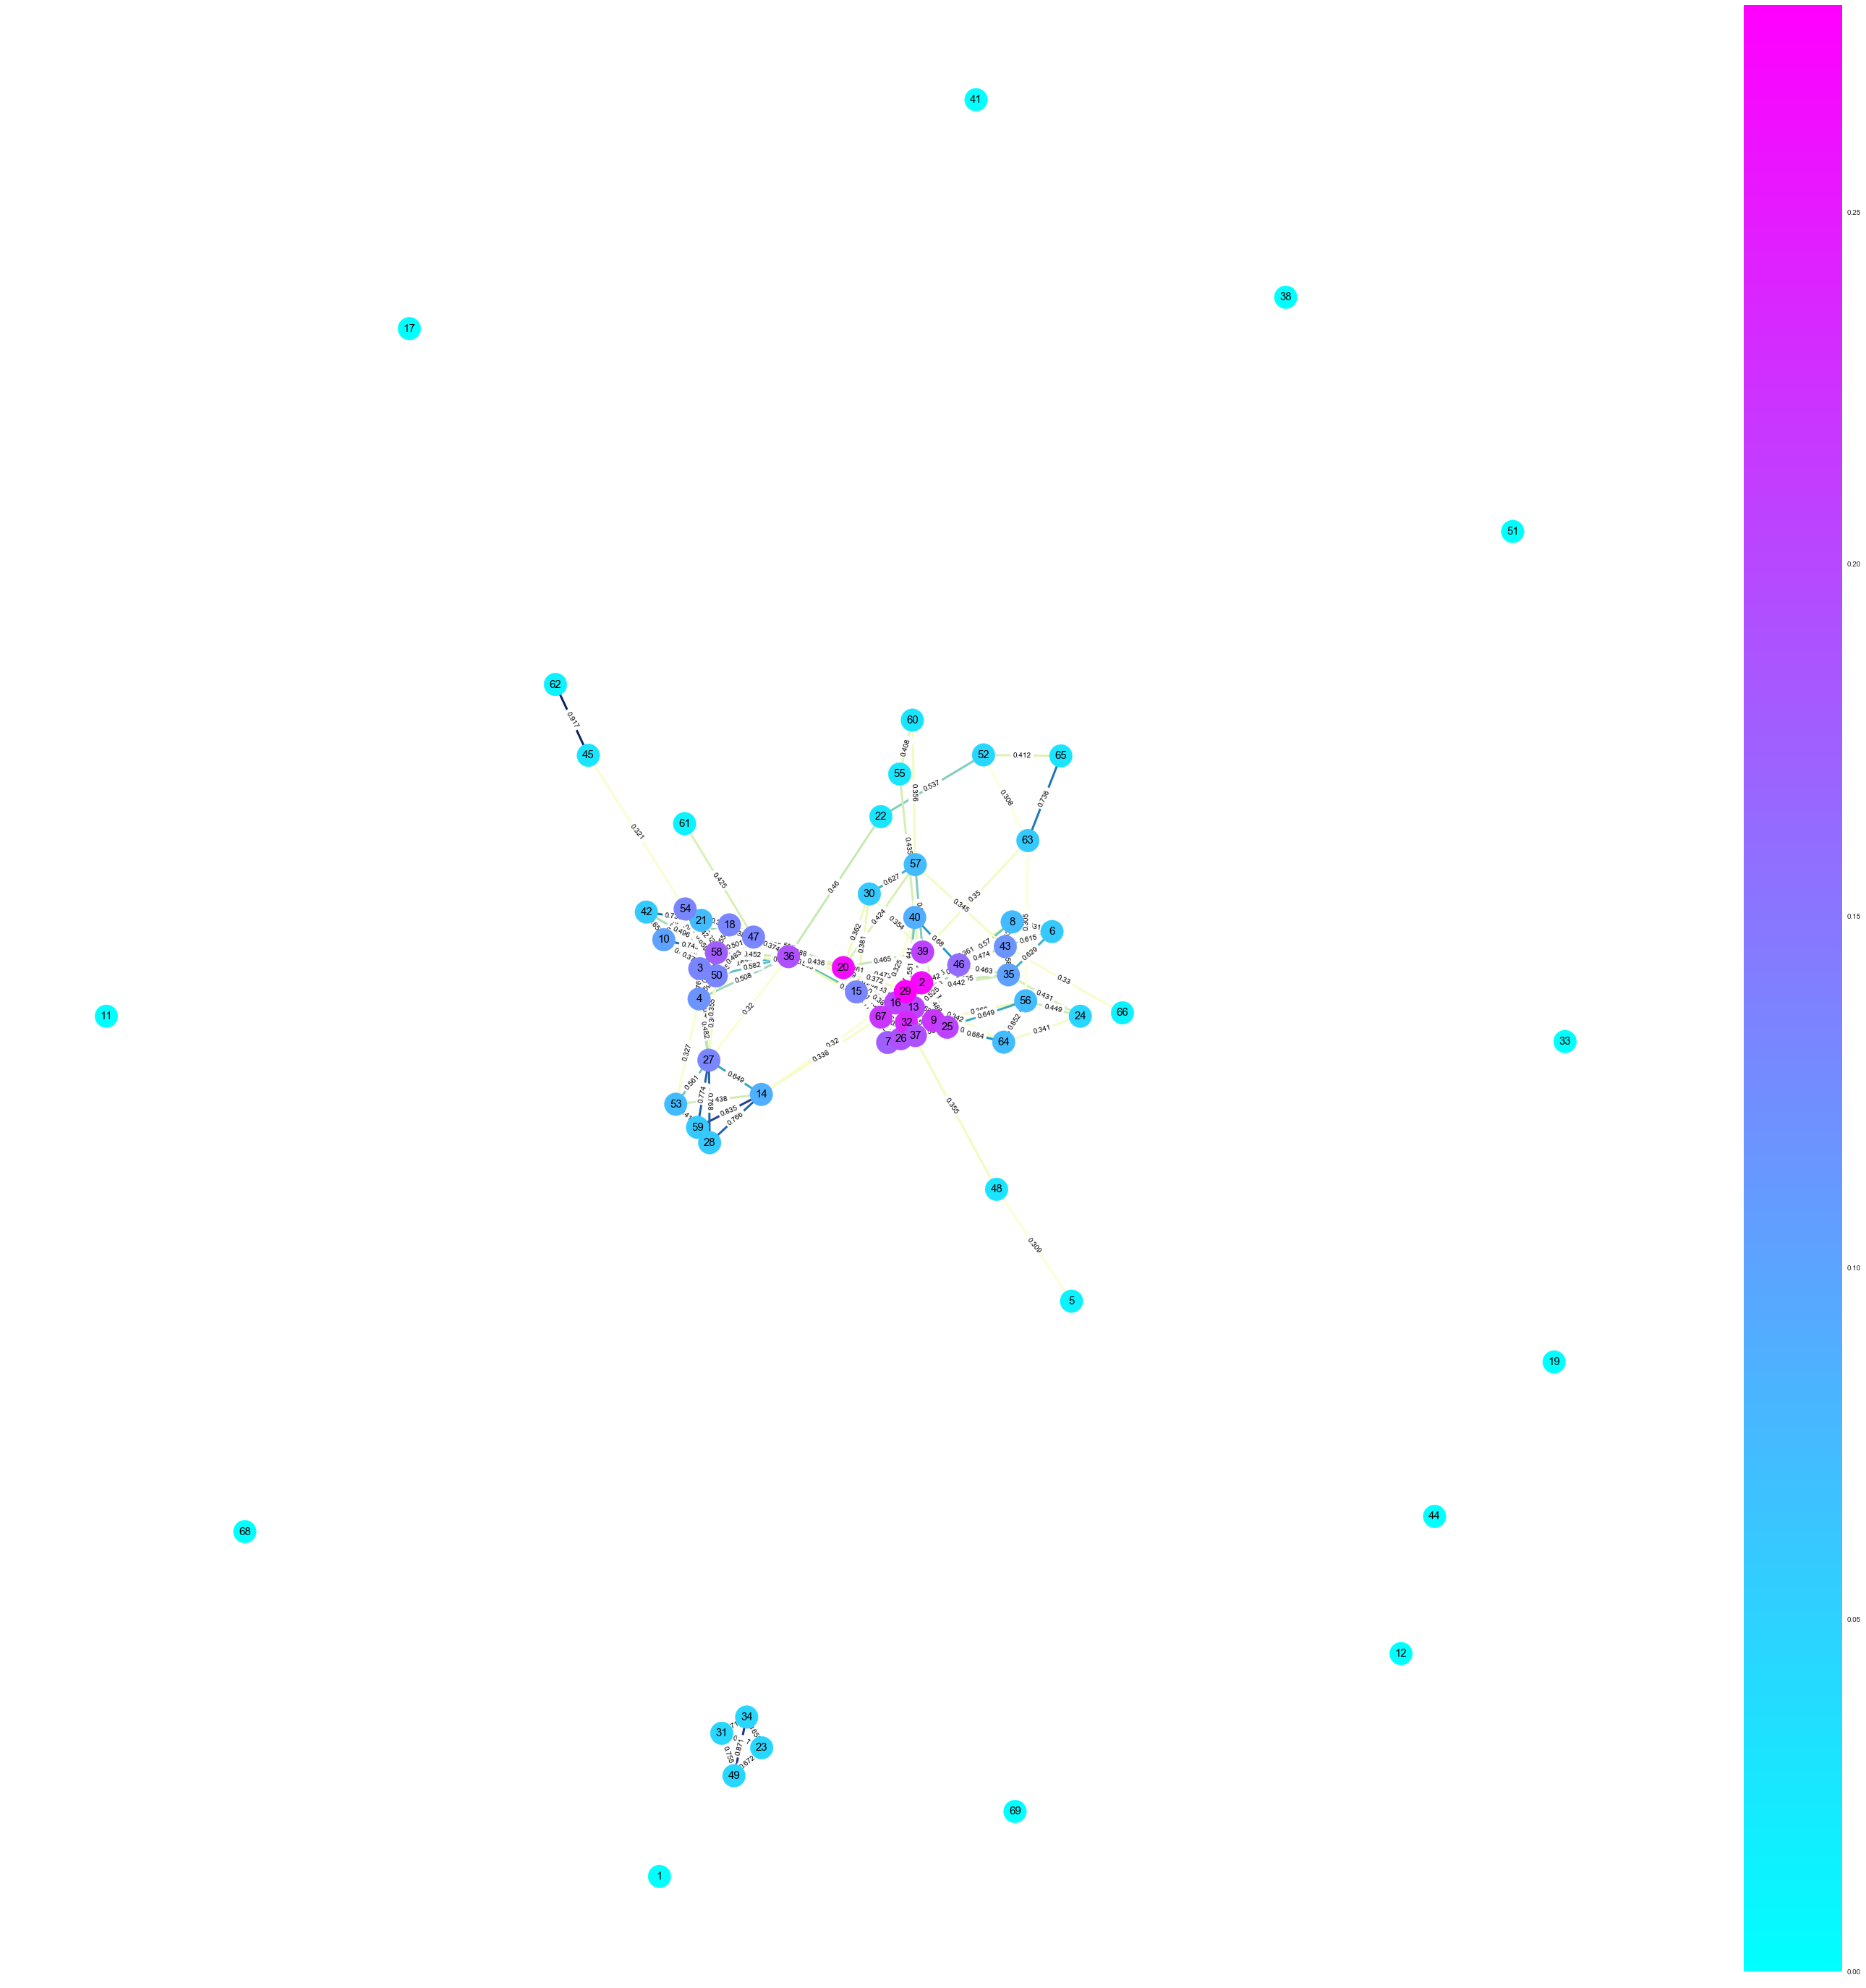

In [10]:
plot_by_color(drd87_open_arms.network, nx.degree_centrality, figsize=(50,50))

# We plot the network of drd87's neurons in the open arms. Note: nodes are colored by their corresponding degree centrality.

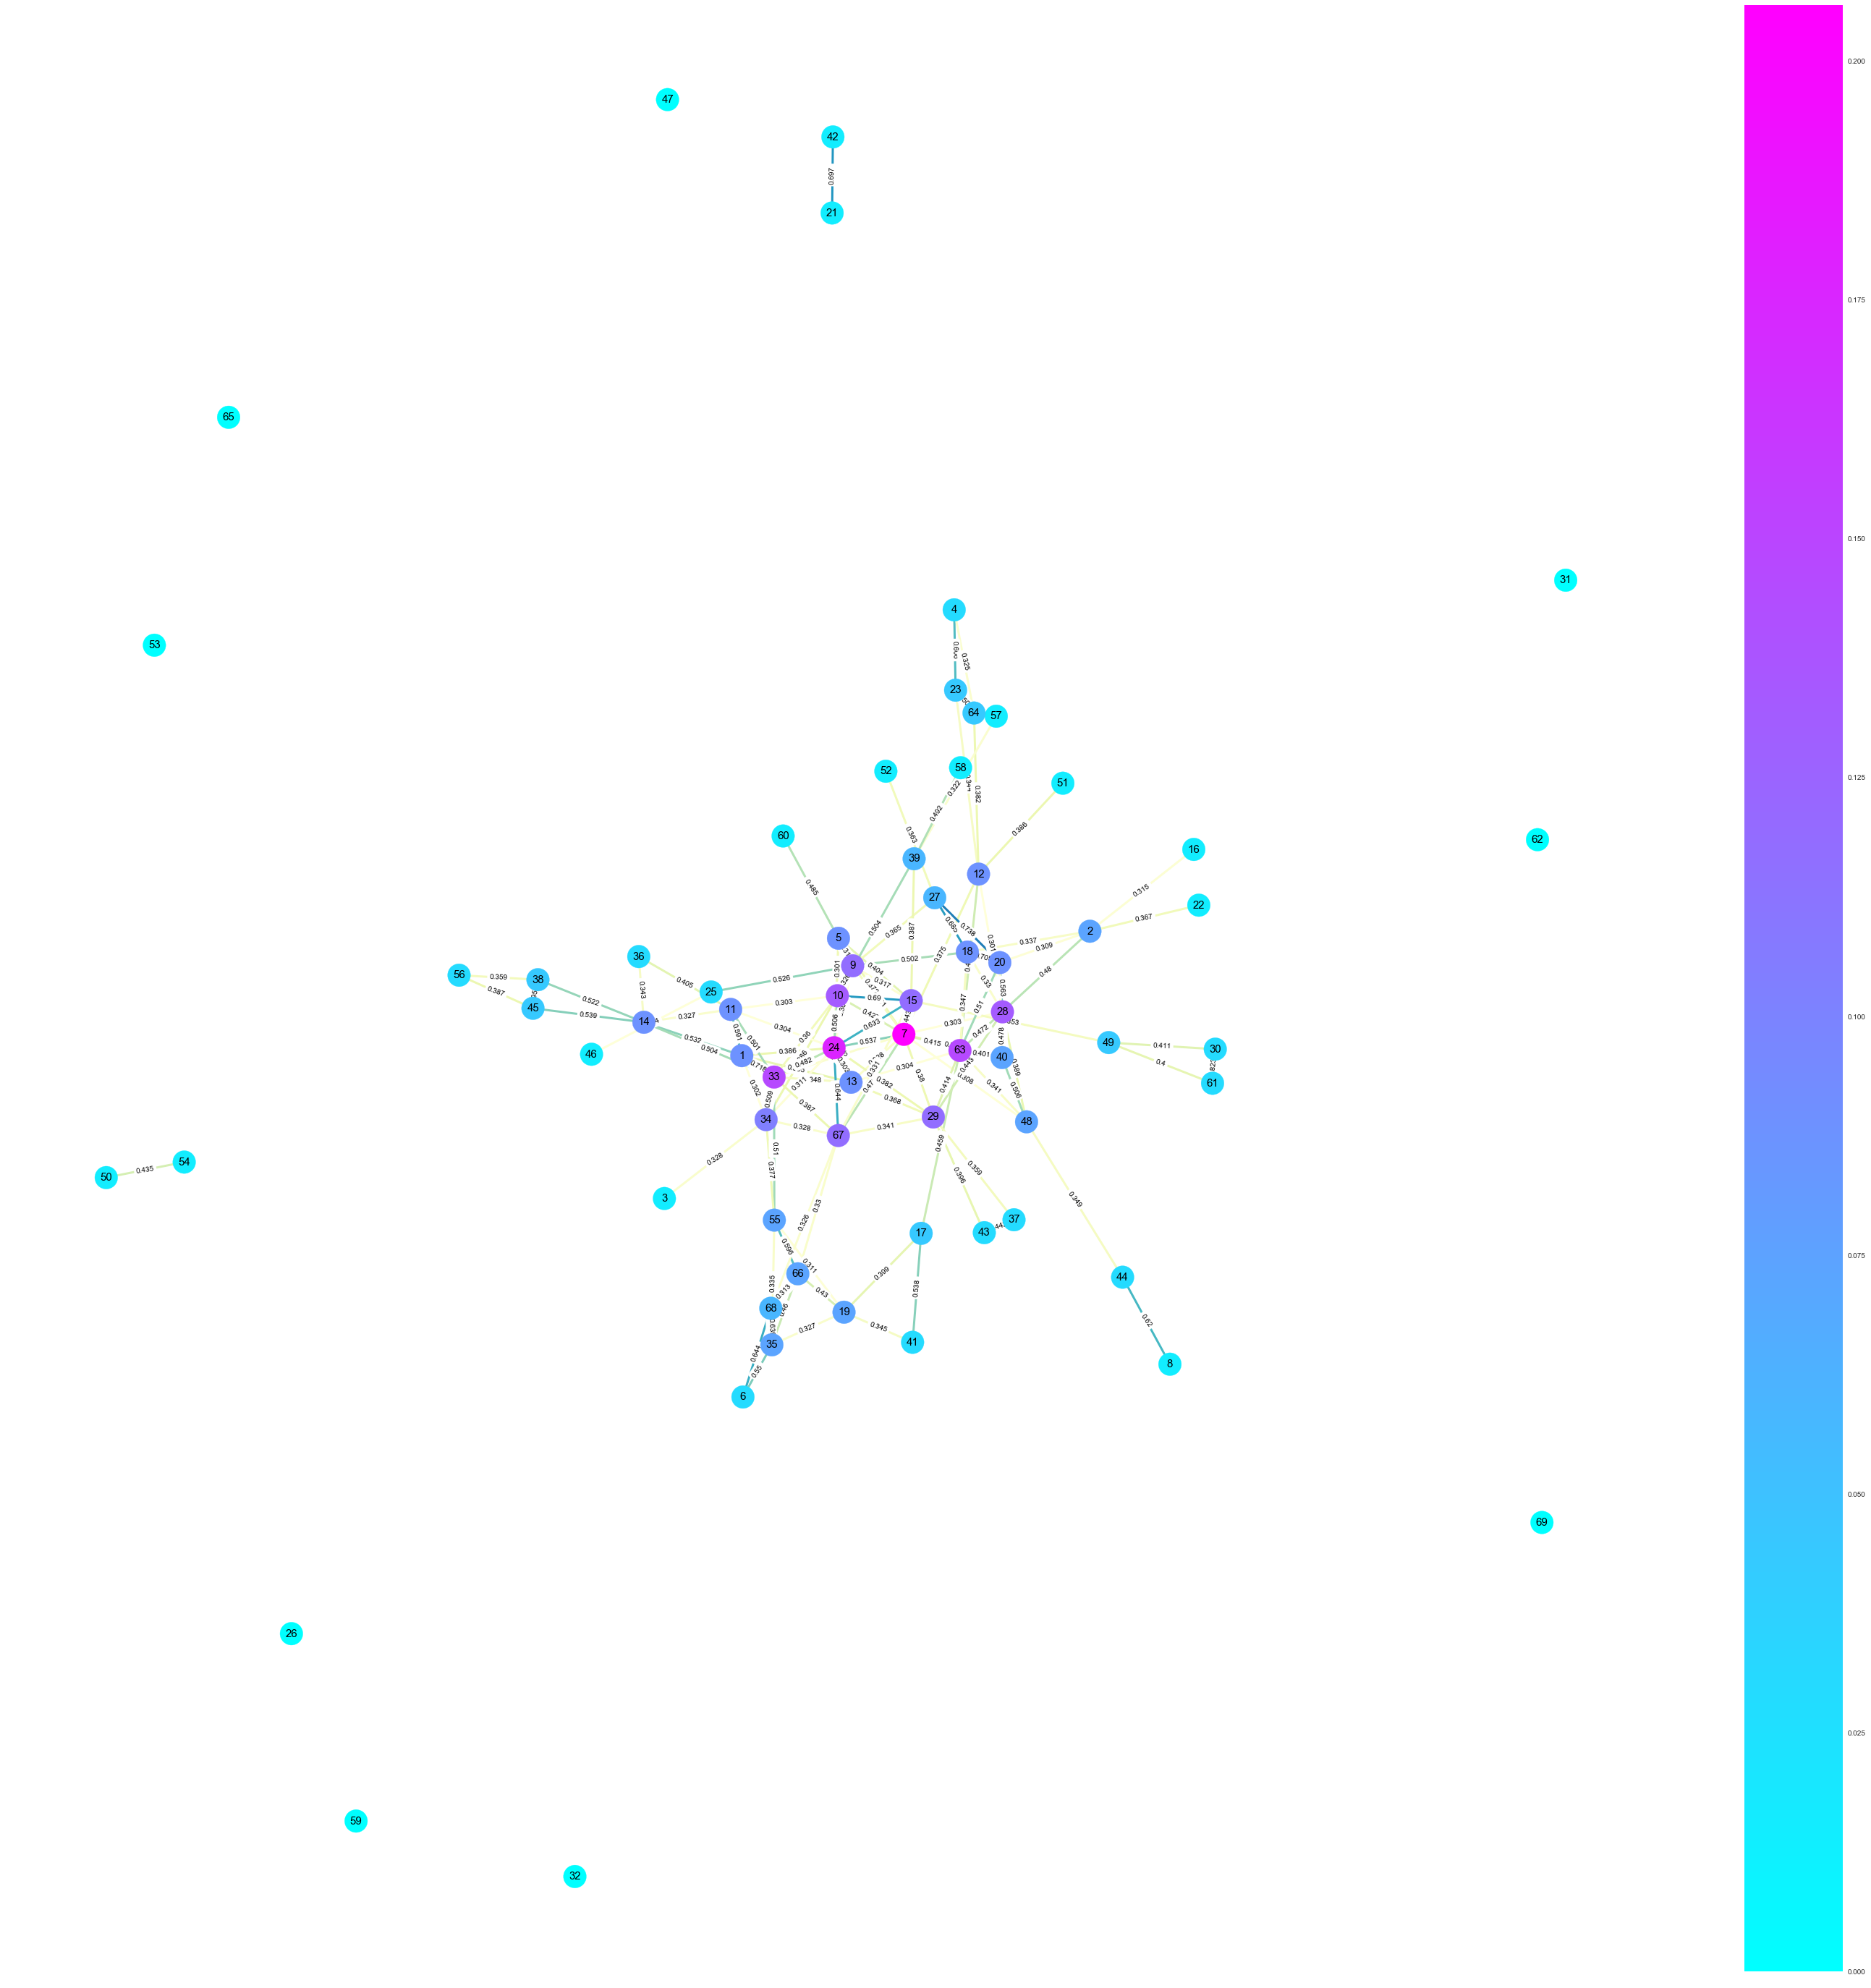

In [11]:
plot_by_color(drd87_closed_arms.network, nx.degree_centrality, figsize=(50,50))

# Now we will plot the network of neurons of drd87, where each neuron is colored by it's corresponding selectivity. 

### We accomplish this as follows:
### 0. Get all the data and process it as need be

In [12]:
data = pd.read_csv("/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv", header=None)
_, AUC_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

In [13]:
behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

behavior_df = pd.read_csv("/Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv", header=None)
behavior_df.columns = behavior_column_names
behavior_df = au.downsample_dataframe(behavior_df, 3)

# Define what constitutes as a running frame
VELOCITY_CUTOFF = 4;

# Adds "Running_frames" column to the end of the behavior Dataframe 
behavior_df["Running_frames"] = np.where(behavior_df["Velocity"] > VELOCITY_CUTOFF, 1, 0)

In [14]:
neuron_concated_behavior = AUC_dataframe.join(behavior_df, how="left")

In [15]:
real_diff_of_means = au.set_real_diff_df(neuron_concated_behavior, AUC_dataframe, "OpenArms_centerpoint", "ClosedArms_centerpoint")
real_diff_of_means

,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron60,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69
d,-4.19561,6.9537,5.86234,12.2911,7.6943,-1.0277,1.02405,-0.860894,-3.20938,2.44695,...,9.97405,-1.6101,6.50104,0.434317,5.00547,9.15386,5.86696,0.973809,-1.97104,13.037


## 1. Run a permutation test to determine which neurons are selective/non-selective/unclassifiable

In [16]:
resampled_df = rs.shuffle(20000, neuron_concated_behavior, AUC_dataframe, "OpenArms_centerpoint", "ClosedArms_centerpoint")

## 2. Plot the distributions of all the, neuron, column vectors to see which type of statistical test is appropriate to apply.

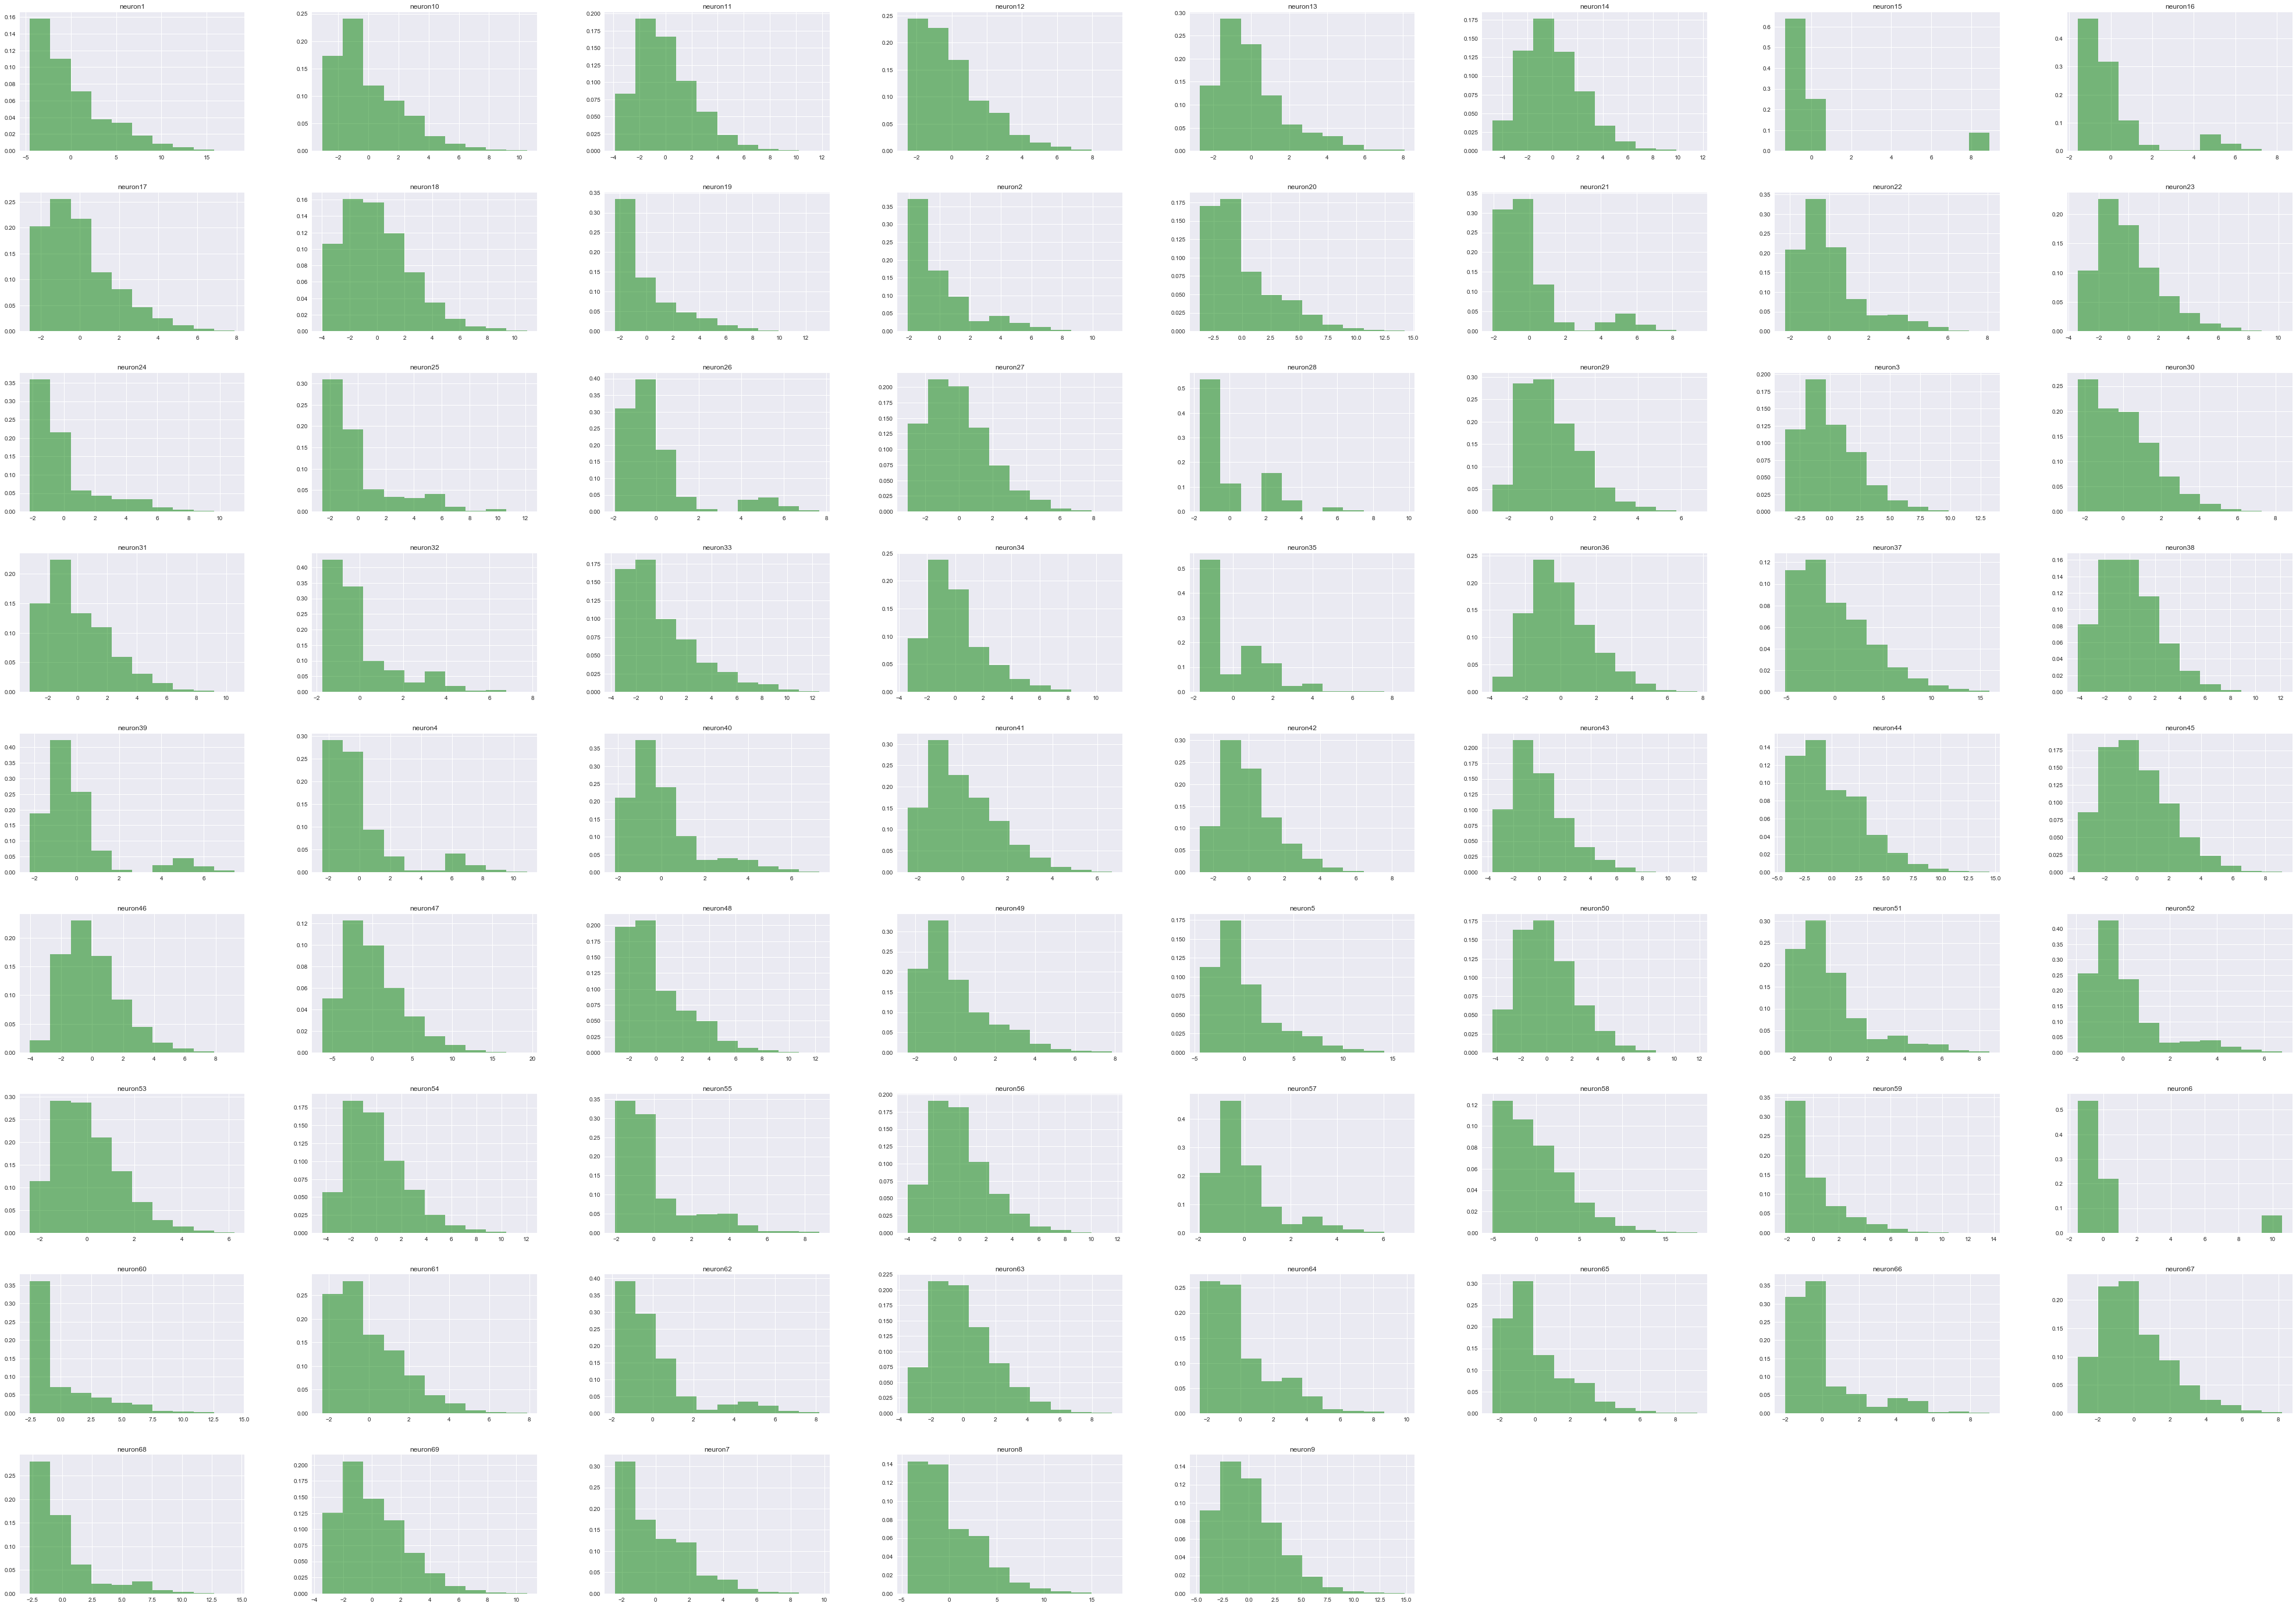

In [17]:
resampled_df.hist(alpha=0.5, color='g', density=True, figsize=(70,50));

## 3. As we can see, the vast majority of the distributions are *not* normal. Thus, we resort to computing the two-sided $p$-value for each, neuron, column vector.

In [18]:
classified_neurons = rs.non_normal_neuron_classifier(AUC_dataframe, resampled_df, real_diff_of_means, p_value=0.125, threshold=10)

## 4. Next, we utilize the *actual* difference of mean values, $\hat{D}$, in order to further classify which behavior each neuron is actually selective for, e.g. OpenArms vs. ClosedArms

In [19]:
deeper_classification = classified_neurons.copy()

for neuron in deeper_classification:
    if real_diff_of_means[neuron].values > 0:
        if deeper_classification[neuron] == "selective":
            deeper_classification[neuron] = "OpenArms_centerpoint"
    elif real_diff_of_means[neuron].values < 0:
        if deeper_classification[neuron] == "selective":
            deeper_classification[neuron] = "ClosedArms_centerpoint"

## 5. Now, we define a color map to apply certain colors to certain types of neuron, and we sort neurons into corresponding lists (by what they are/aren't selective for).
 - Pink: OpenArms_centerpoint
 - Light Green: ClosedArms_centerpoint
 - Light Blue: not-selective
 - Grey: unclassified

In [20]:
def sort_by_selectivity(graph, classifications):
    open_arms_nodes = list()
    closed_arms_nodes = list()
    unclassified_nodes = list()
    not_selective_nodes = list()

    for node in graph.nodes():
        if "{}{}".format("neuron", node) in deeper_classification:
            if deeper_classification["{}{}".format("neuron", node)] == "OpenArms_centerpoint":
                open_arms_nodes.append(node)
            elif deeper_classification["{}{}".format("neuron", node)] == "ClosedArms_centerpoint":
                closed_arms_nodes.append(node)
            elif deeper_classification["{}{}".format("neuron", node)] == "unclassified":
                unclassified_nodes.append(node)
            elif deeper_classification["{}{}".format("neuron", node)] == "not-selective":
                not_selective_nodes.append(node)
                
    return open_arms_nodes, closed_arms_nodes, unclassified_nodes, not_selective_nodes

In [21]:
def plot_by_selectivity(graph, *node_lists, **kwargs):
    plt.figure(figsize=kwargs.get("figsize", (35,35)))
    
    pos = nx.spring_layout(graph, weight="weight") 
    
    node_size = kwargs.get("node_size", 1000)
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, nodelist=node_lists[0], node_color="pink"); 
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, nodelist=node_lists[1], node_color="lightgreen");
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, nodelist=node_lists[2], node_color="lightblue");
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, nodelist=node_lists[3], node_color="grey");

    edges, weights = zip(*nx.get_edge_attributes(graph, "weight").items())

    # edges
    nx.draw_networkx_edges(graph, pos, width=3.0, edge_color=weights, edge_cmap=plt.cm.YlGnBu);

    labels = nx.get_edge_attributes(graph, "weight")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=15, edge_labels=labels)

    plt.axis("off");
    
    save_to_file = kwargs.get("save", False)
    if save_to_file:
        title = kwargs.get("file_name", "Graph.png")
        file_format = kwargs.get("format", "PNG")
        plt.savefig(title, format=file_format)
    
    plt.show();

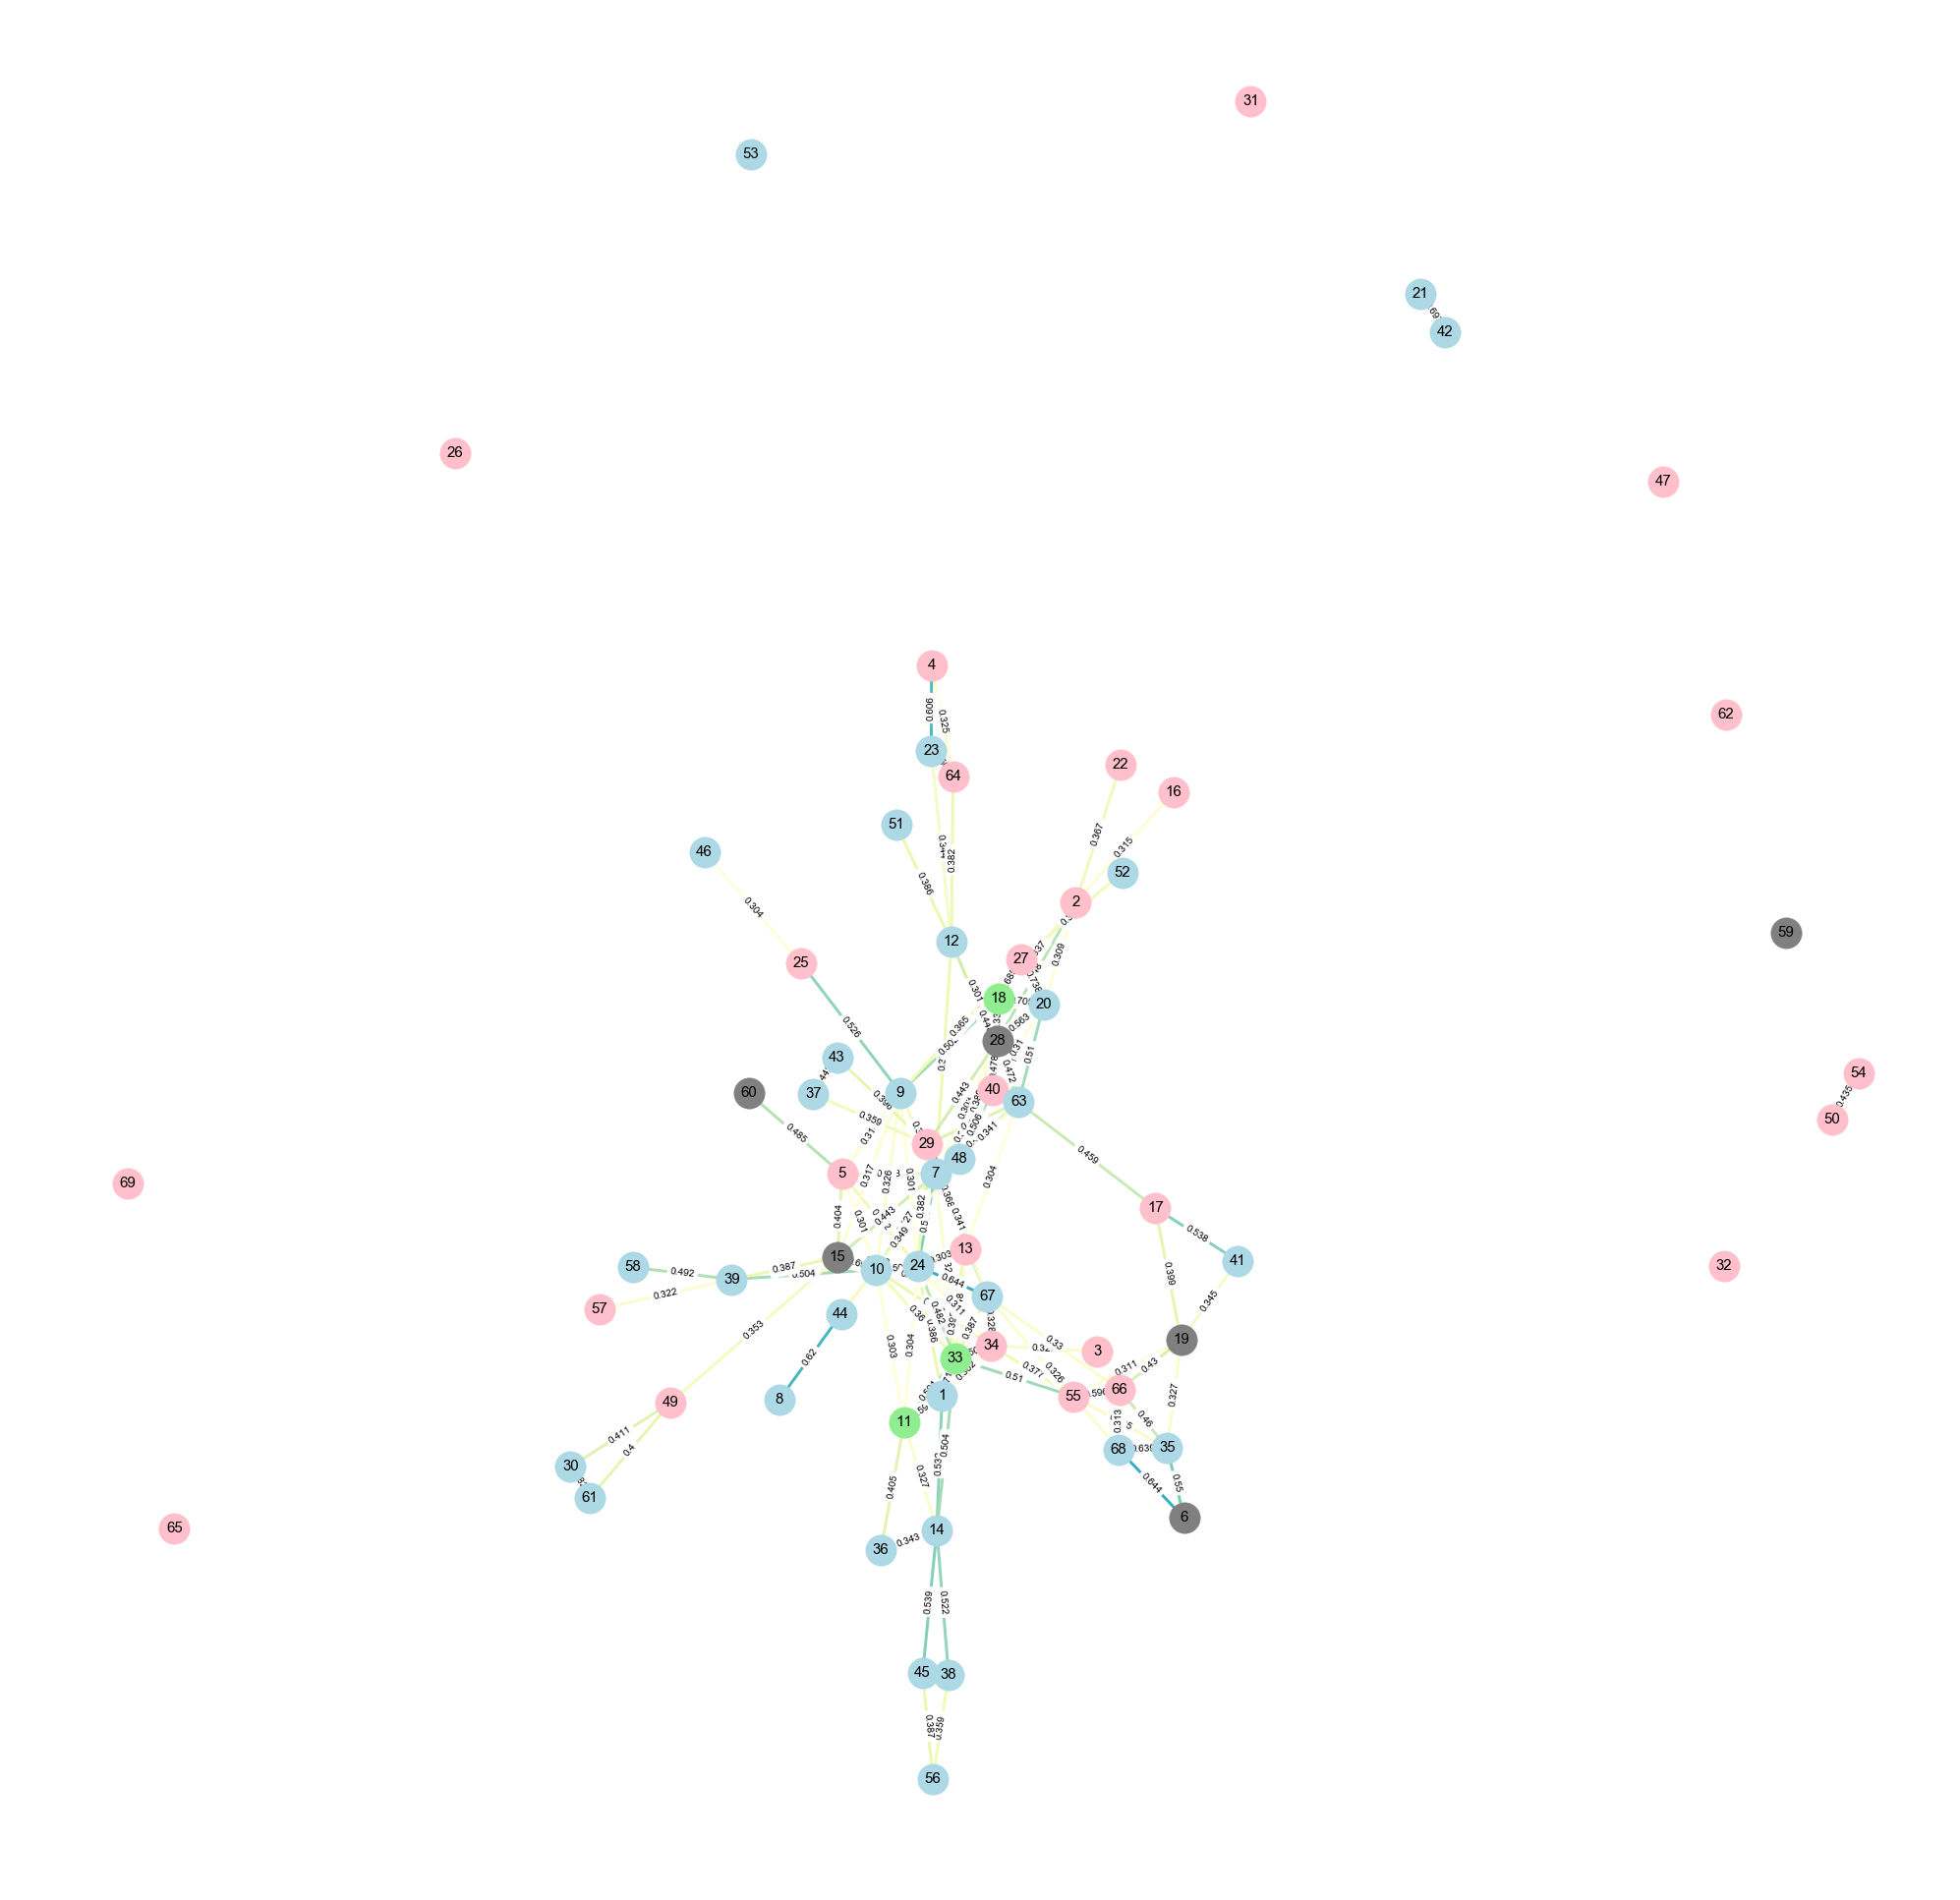

In [27]:
open_arms_nodes, closed_arms_nodes, unclassified_nodes, not_selective_nodes = sort_by_selectivity(drd87_closed_arms.network, deeper_classification)
plot_by_selectivity(drd87_closed_arms.network, open_arms_nodes, closed_arms_nodes, not_selective_nodes, unclassified_nodes, figsize=(35,35), node_size=1000)

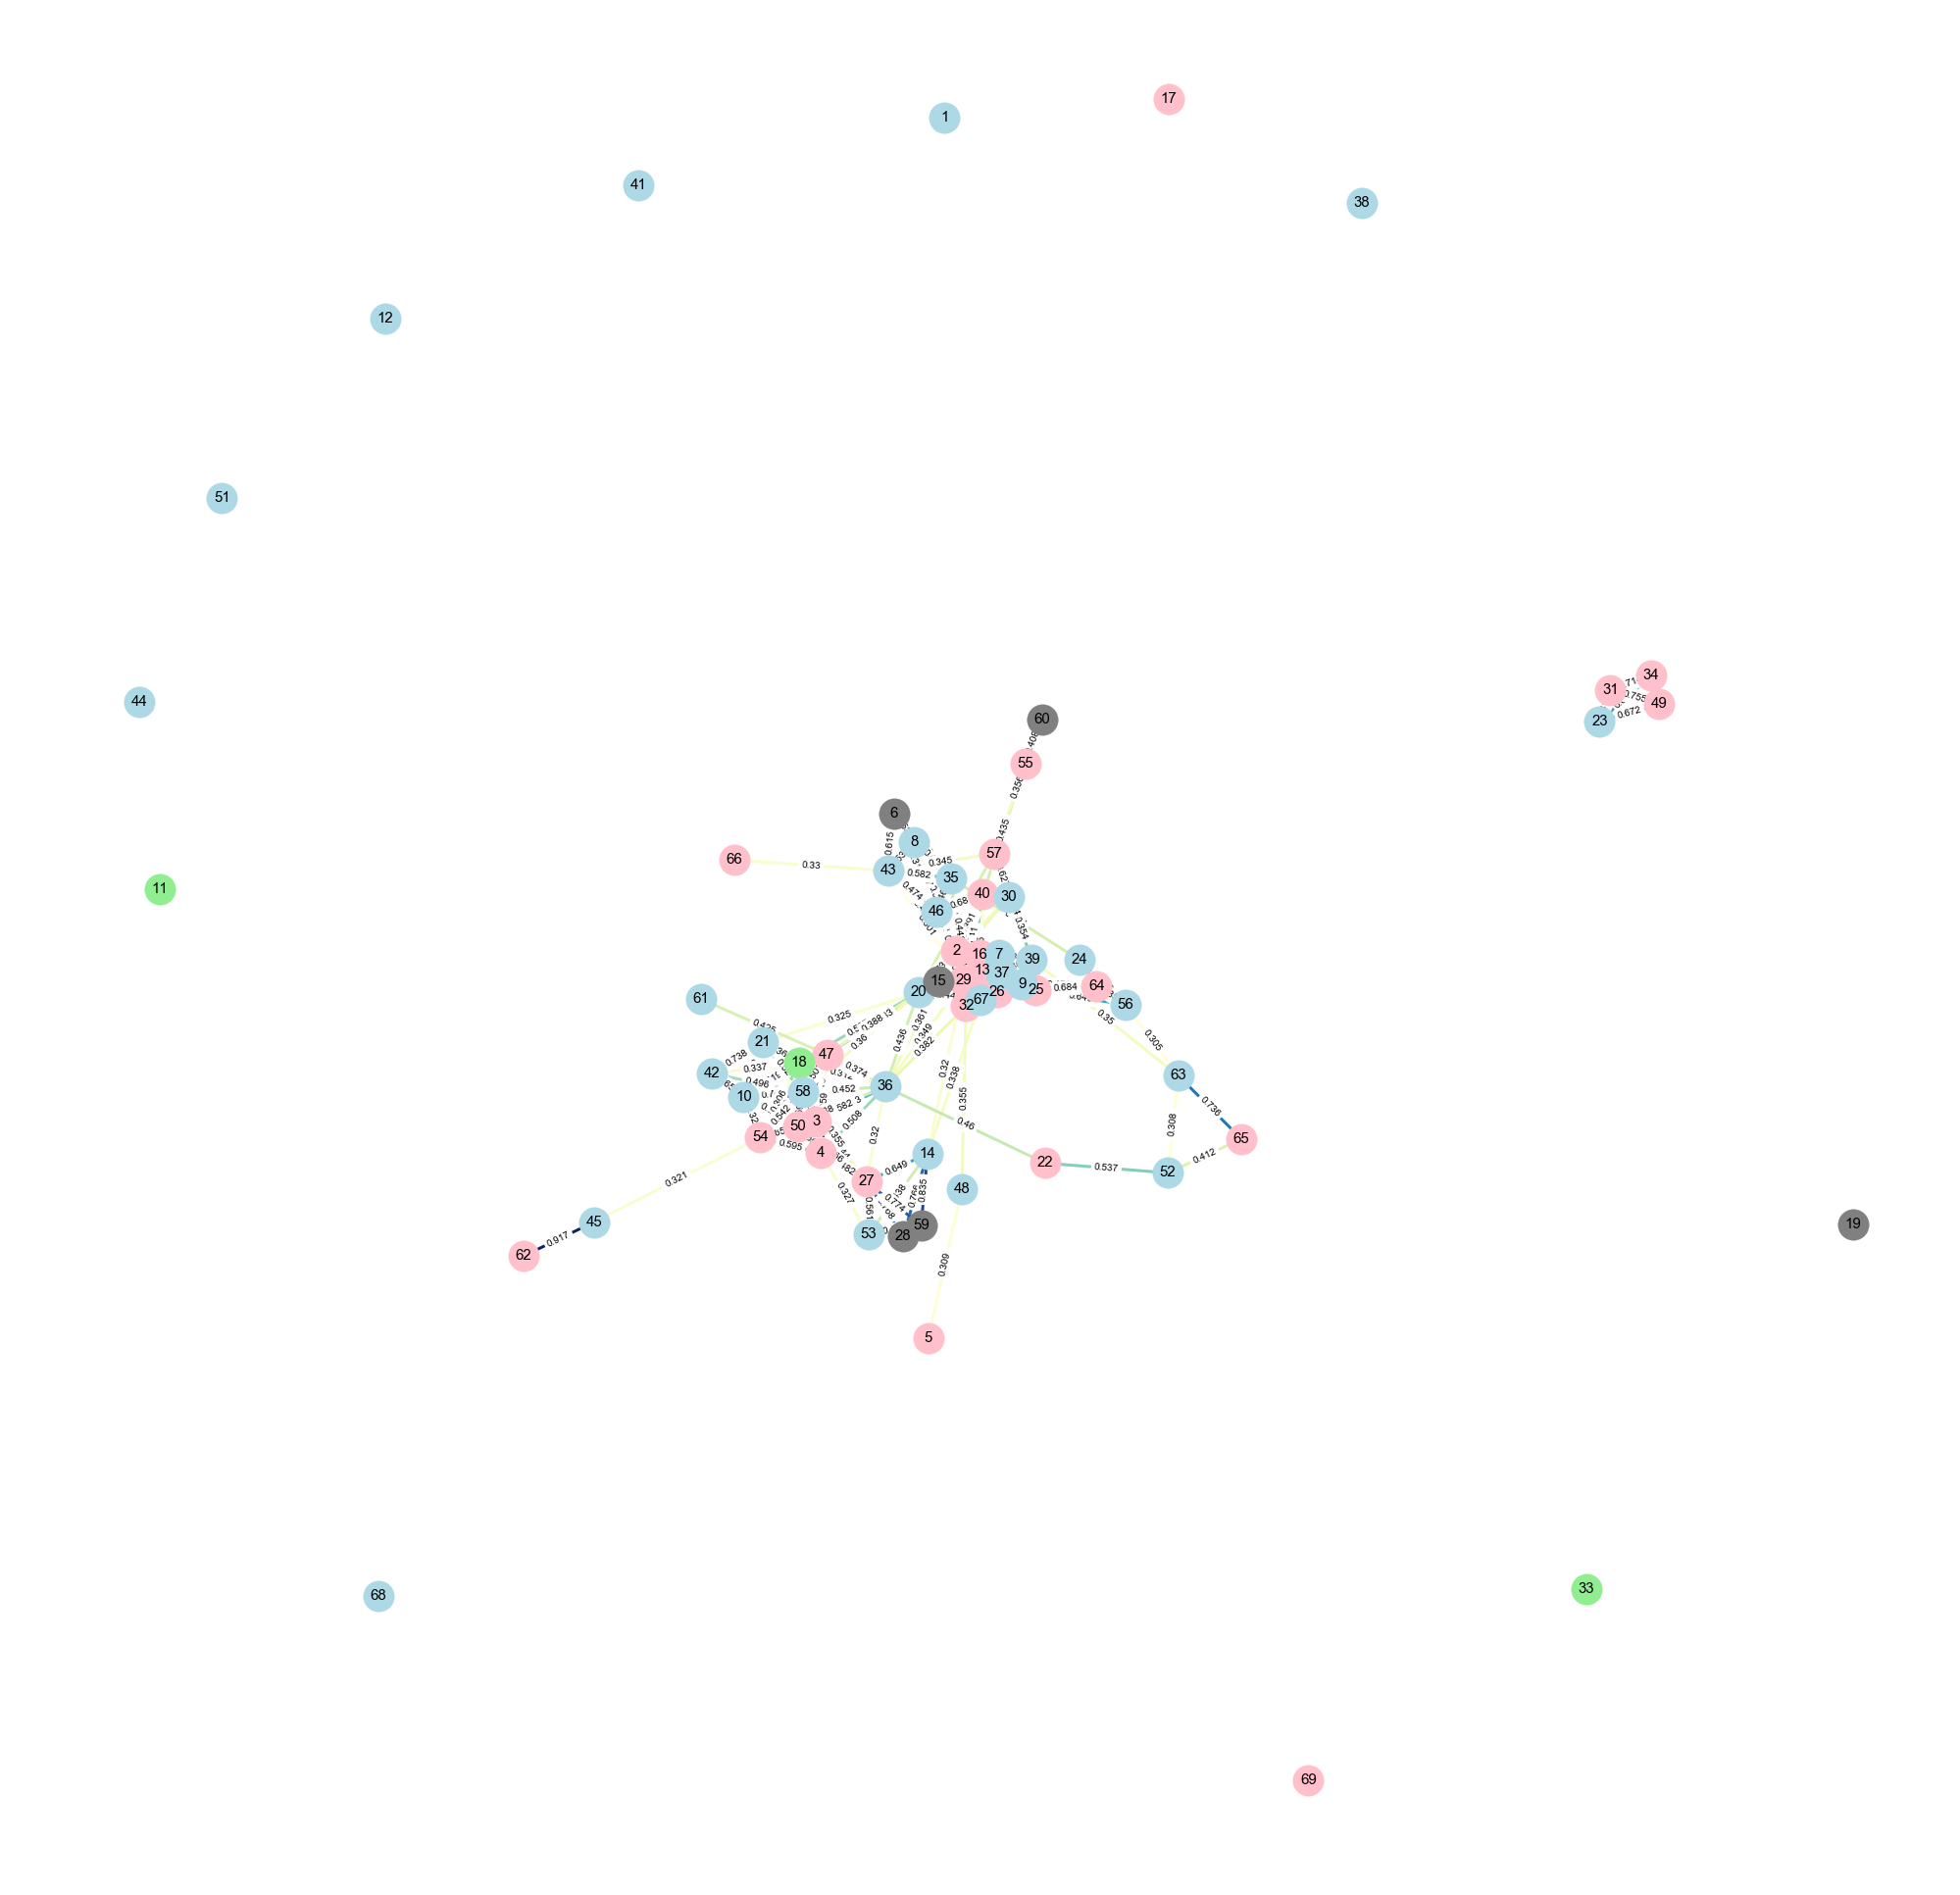

In [28]:
open_arms_nodes, closed_arms_nodes, unclassified_nodes, not_selective_nodes = sort_by_selectivity(drd87_open_arms.network, deeper_classification)
plot_by_selectivity(drd87_open_arms.network, open_arms_nodes, closed_arms_nodes, not_selective_nodes, unclassified_nodes, figsize=(35,35), node_size=1000)

# Now, we plot the neuron network according to its physical representation.

In [29]:
import csv

centroids_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/D87_NO_OFT_POPP_reg/D87_NO_OFT_POPP_cell_centroids.csv")
centroids_dataframe = pd.read_csv(centroids_directory, header=None)

In [30]:
for row in centroids_dataframe.itertuples():
    print(row[1], row[2])

168.9 105.32
98.555 83.73700000000001
71.553 121.35
166.77 93.585
40.15 181.78
137.82 89.565
204.14 111.79
129.82 117.38
83.302 95.104
165.36 83.714
50.34 118.47
113.85 64.641
96.72399999999999 204.35
78.262 157.9
113.93 47.775
53.935 69.922
168.73 26.319000000000003
61.766000000000005 111.39
181.18 55.56
149.27 87.37200000000001
104.85 122.88
99.14299999999999 120.02
30.188000000000002 133.54
84.22200000000001 110.14
78.949 42.992
168.44 208.59
92.742 216.99
48.586000000000006 154.87
68.968 74.446
140.45 65.363
46.983000000000004 164.55
78.119 124.76
115.39 104.27
144.79 51.96
157.73 102.23
135.77 201.31
103.48 29.034000000000002
203.06 87.47200000000001
92.18799999999999 140.96
176.17 98.625
120.82 55.24
90.70299999999999 79.83800000000001
186.11 92.86399999999999
166.06 117.35
49.713 130.94
103.27 108.61
170.72 48.87
181.36 121.98
131.27 85.223
73.765 149.47
57.492 87.165
46.461999999999996 100.13
193.35 77.928
142.52 46.534
32.944 126.94
183.67 82.389
76.637 64.006
72.722 179.35
49